## Latent variable models for systems neuroscience

In this notebook we will extend the ideas developed for _regression_ to the setting of latent variable models.
In a regression setting, we're generally given a dataset of the form $\mathcal{D} = \{ X, Y \}$, where $Y$ is some observed quantity such as neural activity, and $X$ is a set of regressors such as motor output or some task variable.
In the latent variable setting, we _only_ observe $Y$ and need to _infer_ $X$ from the data.
This generally necessitates that we postulate a set of simplifying assumptions, such as $X$ being _low dimensional_ or $Y$ being related to $X$ via a simple linear or smooth mapping.

In the regression setting, we thus learned a function $Y = f_\theta(X)$ with the parameters $\theta = \text{argmax} p(Y|X)$ being learned by maximum likelihood learning.
Since we no longer know $X$ in the LVM setting, we have to integrate it out such that our hyperparameters are given by $\theta = \text{argmax}_\theta(p_\theta(Y))$, where $p_\theta(Y) = \int_X(p_\theta(Y|X) p_\theta(X) dX)$ is the _marginal likelihood_, and we have explicitly indicated a dependence of our generative model on $\theta$.
For a particular $\theta$, we can then do _inference_ to find a distribution over latent variables given the data:\
$p(X|Y) \propto p(Y|X) p(X)$.

For most models, this inference step can be very difficult.
This is the reason why linear-Gaussian models are so popular in much of scientific research, as the resulting distributions are jointly Gaussian which allows for closed form inference.
For more complicated generative models, we often have to resort to _approximate inference_ using e.g. variational inference of Monte Carlo-based methods.
We will not discuss the inference step at all in this tutorial but simply note that tractable inference in generative models is a very active area of research.

In the following, we will instead try to understand how the _assumptions_ we make in our generative model can affect the results of our analyses.


### Table of contents

1. [**Generate two example datasets**](#syn)
2. [**Principal component analysis (PCA)**](#PCA)
3. [**Kalman filter**](#KF)
4. [**Gaussian process factor analysis (GPFA)**](#GPFA)
5. [**Gaussian process latent variable model**](#GPLVM)

### Load some packages and set global parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import mgplvm as mgp
import torch
import time
from jax import numpy as jnp
import jax.random as jr
from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM
from sklearn.decomposition import PCA

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
cm = 1/2.54
plt.rcParams['font.size'] = 22
np.random.seed(1)

### global LVM parameters ###
D = 2
T = 150
N = 30

loading


### Define some functions for plotting and model construction

In [2]:
def plot_lats(X, c = 'k', cmap = None, vmin = None, vmax = None, title = ''):
    plt.figure(figsize = (9*cm, 8*cm))
    plt.scatter(X[0, :], X[1, :], c = c, cmap = cmap, s = 50, vmin = vmin, vmax = vmax)
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(title)
    plt.show()
    plt.close()
    return

def comp_lats(Xs, cs = ['k', 'k'], cmap = None, vmin = None, vmax = None, titles = ['', '']):
    fig, axs = plt.subplots(1, 2, figsize = (19*cm, 8*cm))
    Xs = [zscore(X) for X in Xs]
    for i in range(2):
        axs[i].scatter(Xs[i][0, :], Xs[i][1, :], c = cs[i], cmap = cmap, s = 50, vmin = vmin, vmax = vmax)
        axs[i].set_xticks([-2, 0, 2])
        axs[i].set_xlabel(r'$x_1$')
        axs[i].set_title(titles[i])
    axs[1].set_yticks([])
    axs[0].set_yticks([-2, 0, 2])
    axs[0].set_ylabel(r'$x_2$')
    plt.show()
    plt.close()
    return

def plot_both_lats(X, c2):
    T = X.shape[1]
    fig, axs = plt.subplots(1, 2, figsize = (19*cm, 8*cm))
    axs[0].scatter(X[0, :], X[1, :], c = np.arange(T), cmap = 'Greys', s = 50, vmin = -T/4, vmax = T)
    axs[1].scatter(X[0, :], X[1, :], c = c2, cmap = 'Greys', s = 50, vmin = np.amin(c2)-0.2, vmax = np.amax(c2))
    axs[0].set_xticks([-2, 0, 2])
    axs[1].set_xticks([-2, 0, 2])
    axs[0].set_yticks([-2, 0, 2])
    axs[1].set_yticks([])
    axs[0].set_xlabel(r'$x_1$')
    axs[1].set_xlabel(r'$x_1$')
    axs[0].set_ylabel(r'$x_2$')
    axs[0].set_title('time')
    axs[1].set_title('tuning')
    plt.show()
    plt.close()
    return
    
def plot_activity(mat, title = ''):
    plt.figure(figsize = (18*cm, 8*cm))
    plt.imshow(mat, cmap = 'Greys', aspect = 'auto', vmin = np.quantile(mat, 0.01), vmax = np.quantile(mat, 0.99))
    plt.xlabel('time')
    plt.xticks([])
    plt.ylabel('neurons')
    plt.yticks([])
    plt.title(title)
    plt.show()
    plt.close()
    return

def plot_tuning(mat, Xt, title = '', n = 0):
    Nt = int(np.sqrt(Xt.shape[1]))
    mat = mat[n, :].reshape(Nt, Nt) #just one neuron
    plt.figure(figsize = (9*cm, 8*cm))
    plt.imshow(mat, cmap = 'coolwarm', extent = (Xt[0,0], Xt[0,-1], Xt[1,0], Xt[1,-1]), origin = 'lower')
    plt.show()
    return

def comp_tuning(mats, Xts, titles = ['', ''], n = 0):
    fig, axs = plt.subplots(1, 2, figsize = (19*cm, 8*cm))
    for i in range(2):
        Xt = Xts[i]
        Nt = int(np.sqrt(Xt.shape[1]))
        mat = mats[i][n, :].reshape(Nt, Nt) #just one neuron
        axs[i].imshow(mat, cmap = 'coolwarm', extent = (Xt[0,0], Xt[0,-1], Xt[1,0], Xt[1,-1]), origin = 'lower')
        axs[i].set_title(titles[i])
    plt.show()
    plt.close()
    return

def zscore(X):
    return (X - np.mean(X, axis = 1)[:, None]) / np.std(X, axis = 1)[:, None]

def eval_lats(Xtest, Xtrue):
    Xtest, Xtrue = [zscore(X) for X in [Xtest, Xtrue]]
    dists_test = np.sqrt(np.sum((Xtest[:, None, :] - Xtest[..., None])**2, axis = 0)).flatten()
    dists_true = np.sqrt(np.sum((Xtrue[:, None, :] - Xtrue[..., None])**2, axis = 0)).flatten()
    plt.figure(figsize = (9*cm, 8*cm))
    plt.scatter(dists_true, dists_test, marker = ".", s = 10, alpha = 0.5)
    plt.xlabel('true dists')
    plt.ylabel('inf dists')
    plt.title('r = '+str(np.round(pearsonr(dists_test, dists_true)[0], 2)))
    plt.show()
    return

def fit_mgplvm_data(Y, d_fit, linear = True):
    ### set some parameters for fitting ###
    ntrials = 1
    ### construct the actual model ###
    device = mgp.utils.get_device()
    print(device)
    lik = mgp.likelihoods.Gaussian(N, Y=Y[None, ...]) # we use a Gaussian likelihood
    manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space for bGPFA (see Jensen et al. 2020 for alternatives)
    fit_ts = torch.tensor(np.arange(T))[None, None, :].to(device) # put our time points on GPU/CPU
    var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = 4) # circulant variational GP posterior (c.f. Jensen & Kao et al. 2021)
    lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
    
    if linear:
        mod = mgp.models.Lvgplvm(N, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y[None, ...], learn_scale = False, ard = True, rel_scale = 1).to(device) #create bGPFA model with ARD
    else:
        n_z = 15 #number of inducing points (c.f. Hensman et al., 2015)
        z_gplvm = manif.inducing_points(N, n_z) #initialize inducing points
        kernel = mgp.kernels.QuadExp(N, manif.distance)  # Use an exponential quadratic (RBF) kernel
        mod = mgp.models.SvgpLvm(N, T, ntrials, z_gplvm, kernel, lik, var_dist, lprior, whiten=True).to(device)
    
    train_ps = mgp.crossval.training_params(max_steps = 1001, n_mc = 10, lrate = 5e-2, print_every = 500)
    data = torch.tensor(Y[None, ...]).to(device)
    mod_train = mgp.crossval.train_model(mod, data, train_ps)
    X = mod.lat_dist.lat_mu.detach().cpu().numpy()[0, ...].T # extract inferred latents ('mu' has shape (ntrials x T x d_fit))
    return X, mod
    

def fit_gpfa_data(Y, d_fit):
    return fit_mgplvm_data(Y, d_fit, linear = True)

def fit_gplvm_data(Y, d_fit):
    return fit_mgplvm_data(Y, d_fit, linear = False)

<a id='syn'></a>
## Generate two example datasets

One is generated from a linear-Gaussian model (in both the latents and observations).\
One is generated with a Gaussian process prior over both the latents and observations.

We will use these two datasets to illustrate the similarities and differences between various latent variable models commonly used in the literature.

This data could either represent some high-dimensional neural activity driven by a lower-dimensional latent state, or it could represent high-dimensional motor output being resulting from a lower-dimensional motor behavior.

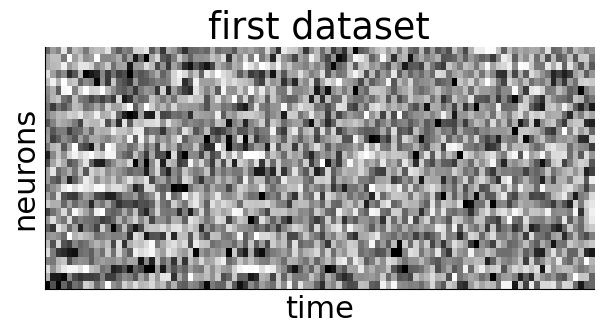

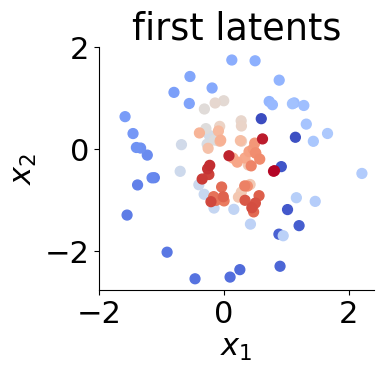

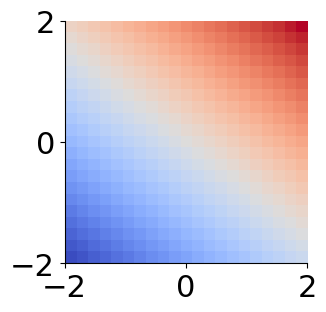

(100, 100) (441, 100) (30, 100) (2, 441) (2, 100)


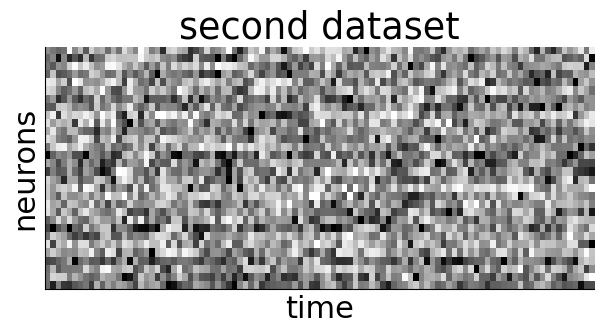

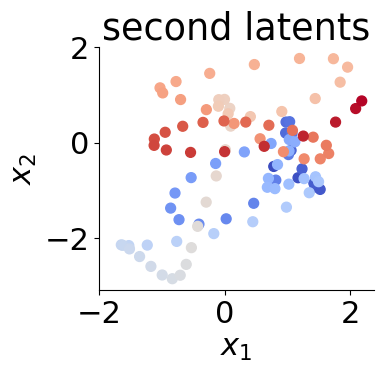

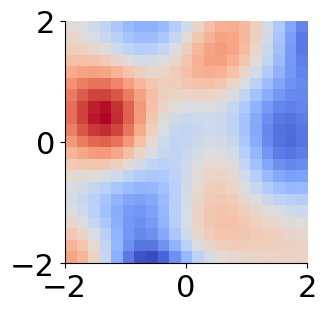

In [3]:
### Generate two datasets

sig_obs = 1.5
np.random.seed(1)
Nt = 21
Xt = np.array([np.tile(np.linspace(-2.0, 2.0, Nt), Nt), np.repeat(np.linspace(-2.0, 2.0, Nt), Nt)])

T = 100
### Kalman filter
A1 = np.array([[0.9, 0.2], [-0.2, 0.9]])
X1 = np.zeros((D, T))
X1[:, 0] = np.array([0.6,0.6])
for t in range(1, T): X1[:, t] = A1@X1[:, t-1] + np.random.normal(0, 0.3, 2)
C1 = np.random.normal(0, 1, (N, D))
Y1 = C1 @ X1 + np.random.normal(0, 2*sig_obs, (N, T))
plot_activity(Y1, title = 'first dataset')
plot_lats(X1, c = np.arange(T), title = 'first latents', cmap = 'coolwarm')
Y1_t = C1 @ Xt
plot_tuning(Y1_t, Xt, title = 'tuning 1', n = 0)

### GPs
ell = 4
K = np.exp(-(np.arange(T)[:, None] - np.arange(T)[None, :])**2/(2*ell**2))
L = np.linalg.cholesky(K+1e-6*np.eye(T))
X2 = np.random.normal(0,1,(2,T))@L.T

ellx = 0.8
Kx = np.exp(-np.sum((X2[..., None] - X2[:, None, :])**2, axis = 0) / (2*ellx**2)) + 1e-2*np.eye(T)
Lx = np.linalg.cholesky(Kx)
Y2 = np.random.normal(0, 1, (N, T))@Lx.T

Ktx = np.exp(-np.sum((Xt[..., None] - X2[:, None, :])**2, axis = 0) / (2*ellx**2))
print(Kx.shape, Ktx.shape, Y2.shape, Xt.shape, X2.shape)
Y2_t = (Ktx @ np.linalg.inv(Kx) @ Y2.T).T

Y2 = Y2+np.random.normal(0, sig_obs, (N,T))

#Y2 = C2 @ X2 + np.random.normal(0, 0.3, (N, T))
plot_activity(Y2, title = 'second dataset')
plot_lats(X2, c = np.arange(T), title = 'second latents', cmap = 'coolwarm')
plot_tuning(Y2_t, Xt, title = 'tuning 2', n = 0)

<a id='PCA'></a>
## Principal component analysis (PCA)

We start by fitting 'principal component analysis'; a very common method in systems neuroscience.
For a given dataset, the principal components (PCs) are given by the _eigenvectors_ of the covariance matrix of the data.
In other words, for a dataset $Y \in \mathbb{R}^{N \times T}$, the PCs are given by $C =$eigvecs$((Y - \hat{Y})^T (Y - \hat{Y}) \in \mathbb{R}^{N \times D}$.
We can then form a _low-dimensional_ representation of our data as $X = C^T Y$.

However, we can also take a _probabilistic_ view of PCA (similar to the probabilistic view of linear regression; see Roweis & Ghahramani for a thorough discussion).
In this case, we assume that the data is generated from a set of normally distributed _latent variables_ \
$X \in \mathbb{R}^{D \times T}$ with $x_{nt} \sim \mathcal{N}(x; 0, 1)$.
We then assume that the _observed_ data $Y = C X + \epsilon$ is a linear function of these latent variables with Gaussian noise, $\epsilon \sim \mathcal{N}(\epsilon; 0, \sigma)$ and $\sigma \rightarrow 0$. 
The linear mapping $C$ is learned by maximizing the likelihood $\mathcal{L} = p(Y) = \int_X p(Y|X) p(X) dX$.

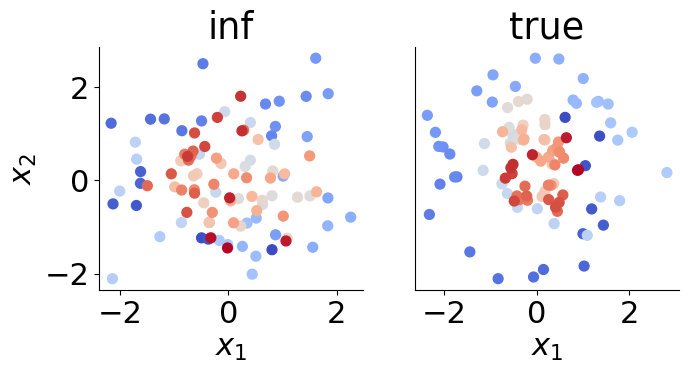

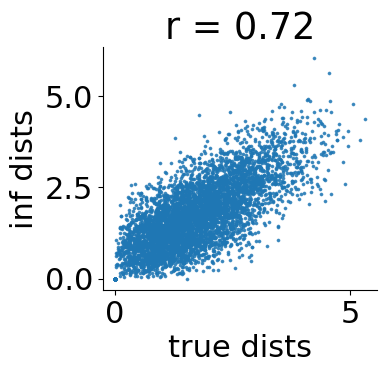

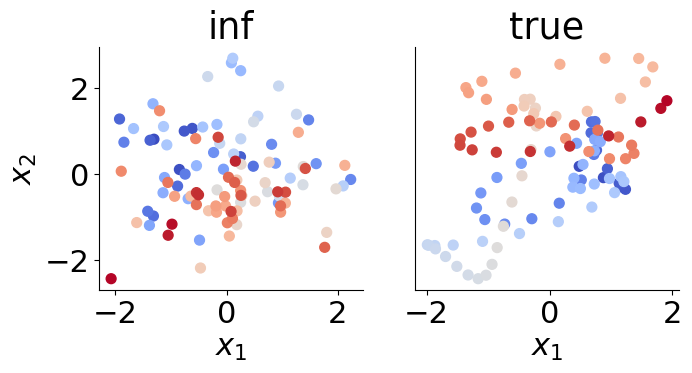

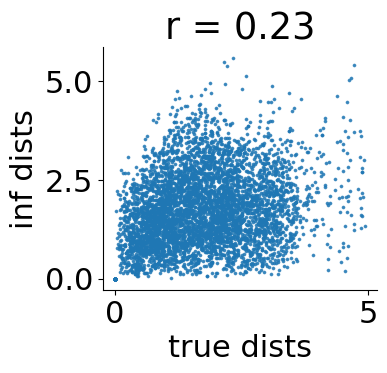

In [4]:
pca = PCA(n_components=D)
Xpca1 = pca.fit_transform(Y1.T).T
comp_lats([Xpca1, X1], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xpca1, X1)

print('\n')

Xpca2 = pca.fit_transform(Y2.T).T
comp_lats([Xpca2, X2], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xpca2, X2)

<a id='KF'></a>
## Kalman filter

One thing we might notice about the analyses above is that our inferred latents look quite a bit noisier than the true latents.
This is because we're only using correlations _across neurons_ to infer latent trajectories (since PCA is modelling the neural covariance matrix).
However, in many cases there are also correlations _across time_, both due to the intrinsic properties of neural circuits and due to autocorrelations in the external world that is being represented.

We can capture these features by using methods that impose an explicit prior over the _transitions_ between latent states, encouraging states nearby in time to be nearby in space.
A common approach to such temporal modelling that builds on our previous ideas of linear Gaussian models is to fit a _linear Gaussian state space model_ (or Kalman filter).
In this case, the transitions between latent states are governed by learned dynamics with Gaussian noise.
The mapping from latent states to observations is still assumed to be linear, but now with a noise model that can be correlated and have different magnitude across neurons (in contrast to PCA where the magnitude of the noise was shared across neurons).

We thus arrive at the following generative model:\
$x_t \sim \mathcal{N}(x_t; A x_{t-1}, Q)$, where $A$ is the _transition matrix_ and $Q$ is the covariance matrix of the _process noise_.\
$y_t \sim \mathcal{N}(y_t; C x_t, R)$, where $R$ is the covariance of the _observation noise_.\
In this case, both the transtion matrix $A$, the factor matrix $C$, and the covariances of the process and observation noise ($Q$ and $R$) are learned by maximizing the likelihood $\mathcal{L} = p(Y) = \int_X p(Y|X) p(X) dX$.


In [5]:
mod_kalman = LinearGaussianConjugateSSM(D, N)
num_iters = 10000
key = jr.PRNGKey(42)
params1, param_props1 = mod_kalman.initialize(key)
params1_t, marginal_lls1 = mod_kalman.fit_em(params1, param_props1, jnp.array(Y1.T), num_iters=num_iters)
params2, param_props2 = mod_kalman.initialize(key)
params2_t, marginal_lls2 = mod_kalman.fit_em(params2, param_props2, jnp.array(Y2.T), num_iters=num_iters)


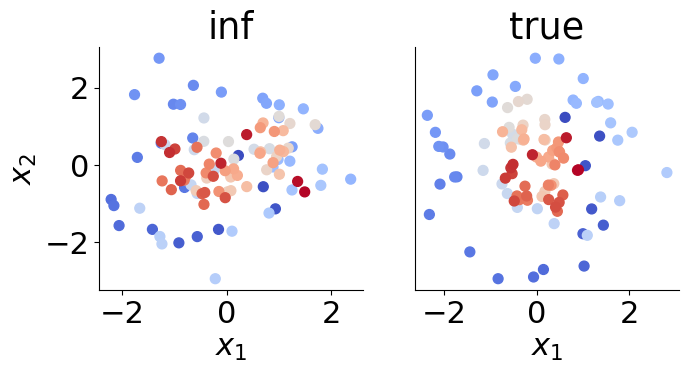

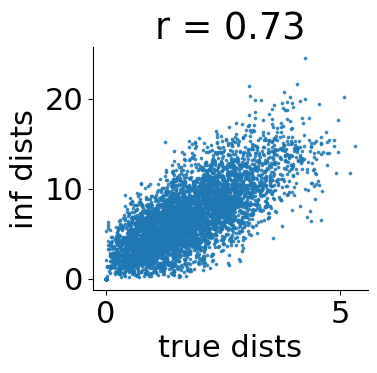

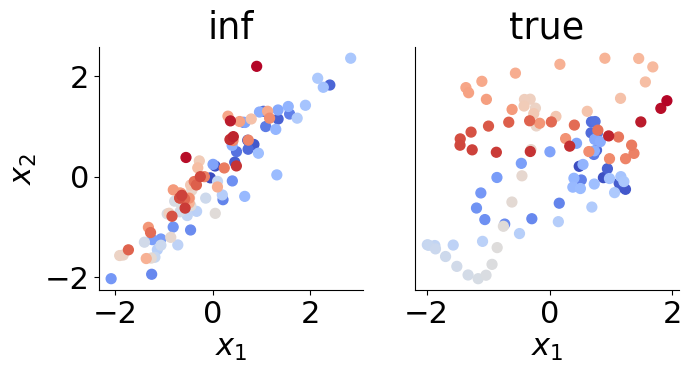

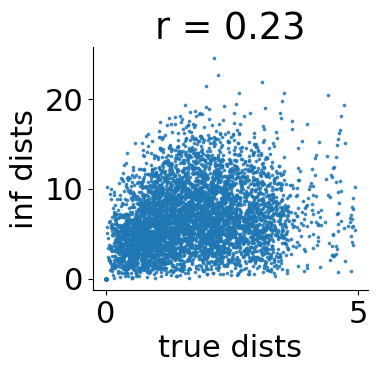

In [6]:
Xkalman1 = np.array(mod_kalman.posterior_predictive(params1_t, jnp.array(Y1.T))[0].T)
Xkalman2 = np.array(mod_kalman.posterior_predictive(params2_t, jnp.array(Y2.T))[0].T)

comp_lats([Xkalman1, X1], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xkalman1, X1)

print('\n')

comp_lats([Xkalman2, X2], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xkalman2, X2)


<a id='GPFA'></a>
## Gaussian process factor analysis (GPFA)

We saw that the Kalman filter above allowed us to capture some of the temporal correlations in the data.
However, it also involves fitting a fairly large number of parameters, which can lead to overfitting in the small data limit.
Additionally, it can only capture autoregressive processes and does not allow us to impose smoothness beyond the first derivative of the latent dynamics.

Another popular method that addresses some of these challenges is GPFA, which places a _Gaussian process_ prior over the latent states as a function of time.
The mapping from latent states to observations is still assumed to be linear, but now with a noise model that can have independent standard deviation across neurons (in contrast to PCA where the noise is shared across output channels).

We thus arrive at the following generative model:\
$x_d \sim \mathcal{GP}(x; 0, K)$, where $K$ is the _covariance matrix_ (usually squared exponential).\
$y_n = c_n X + \epsilon_n$, where $\epsilon_n \sim \mathcal{N}(\epsilon; 0, \sigma_n)$.\
In this case, both the factor matrix $C$ and the noise variances $\sigma_n$ are learned by maximizing the likelihood $\mathcal{L} = p(Y) = \int_X p(Y|X) p(X) dX$.

We note in passing that GPFA can be prone to _oversmoothing_ when using a squared exponential kernel, as illustrated e.g. in Figure S8 of Schimel et al. (2022).

In [7]:
### We now fit GPFA using the mgplvm python package

Xgpfa1, mod_gpfa1 = fit_gpfa_data(Y1, D)
Xgpfa2, mod_gpfa2 = fit_gpfa_data(Y2, D)


cpu
iter   0 | elbo -3.228 | kl  0.000 | loss  3.228 | |mu| 0.050 | sig 1.000 | prior_ell 4.000 |scale 1.026 | lik_sig 3.831 |
iter 500 | elbo -2.541 | kl  0.020 | loss  2.559 | |mu| 0.479 | sig 0.934 | prior_ell 3.741 |scale 0.935 | lik_sig 3.002 |
iter 1000 | elbo -2.540 | kl  0.019 | loss  2.559 | |mu| 0.476 | sig 0.951 | prior_ell 3.780 |scale 0.942 | lik_sig 3.001 |
cpu
iter   0 | elbo -2.441 | kl  0.000 | loss  2.441 | |mu| 0.051 | sig 1.000 | prior_ell 4.000 |scale 0.412 | lik_sig 2.008 |
iter 500 | elbo -1.936 | kl  0.017 | loss  1.953 | |mu| 0.490 | sig 0.973 | prior_ell 4.378 |scale 0.407 | lik_sig 1.649 |
iter 1000 | elbo -1.935 | kl  0.017 | loss  1.952 | |mu| 0.502 | sig 1.011 | prior_ell 6.181 |scale 0.421 | lik_sig 1.647 |


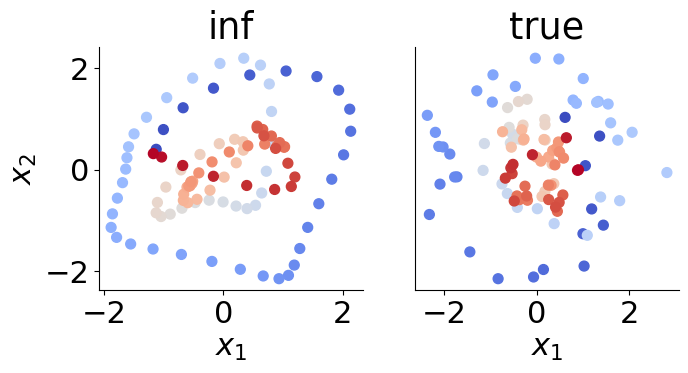

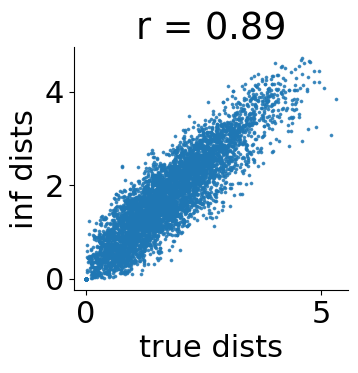

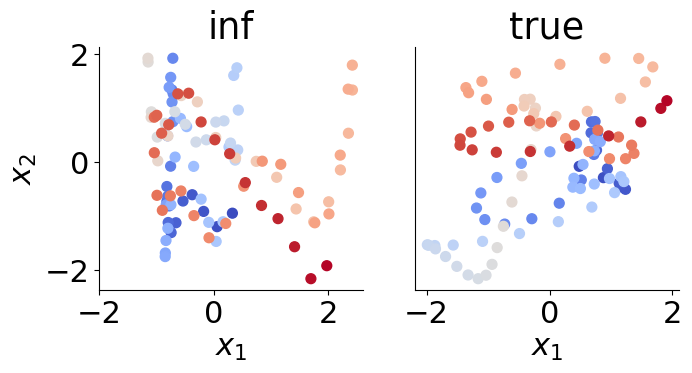

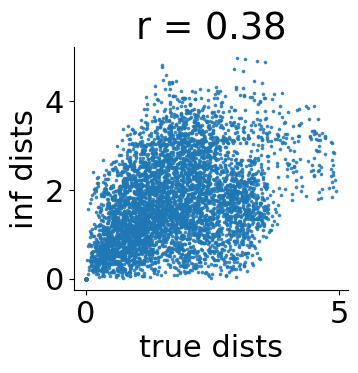

In [8]:
comp_lats([Xgpfa1, X1], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xgpfa1, X1)

print('\n')

comp_lats([Xgpfa2, X2], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xgpfa2, X2)

<a id='GPLVM'></a>
## Gaussian process latent variable model

We might notice from the above analyses that we still fail to learn a reasonable model of the second dataset.
This is because PCA and GPFA assume a _linear_ mapping from the latent space to our observations, which may not always be appropriate for neural data, where e.g. firing rates can have a non-linear dependence on many variables.
However, we can generalize these linear methods to the non-linear domain by considering their Bayesian extensions.
In particular, if we place a _Gaussian prior_ over the factor matrix C, $Y$ becomes a _probabilistic_ function of $X$,
$p(y_n | X) = \mathcal{N}(y_n; X^T X + \sigma_n \mathcal{I})$.
This implies that our neural firing rates are governed by a Gaussian process prior as a function of the latents, but where the kernel is _linear_ (This Bayesian formulation is in fact what is implemented in the mGPLVM library used to fit GPFA above; see Jensen et al., 2021 for details).
In other words, we are doing inference in the space of linear functions to find the one that best describes our data.
However, as we have seen previously, there is _a priori_ no reason to restrict ourselves to this linear domain, and we could instead use a _different_ prior over functions -- for example, a weaker prior which stipulates that neural firing should be a _smooth_ function of the underlying latents.
This is exactly what was done in recent work by Wu et al. (2017, 2018) and Jensen et al. (2020), who instead used squared exponential kernels as a prior over tuning curves.

In this case, our generative model becomes:\
$x_d \sim \mathcal{GP}(x; 0, K_x)$. Note that a squared exponential kernel would yield smooth latents (as in GPFA) while a diagonal kernel would yield _a priori_ iid latents (as in PCA).\
$y_n \sim \mathcal{N}(y_n; K_{y_n} + \sigma_n \mathcal{I})$. Here, a linear kernel recovers (Bayesian) PCA/GPFA while a squared exponential kernel recovers a non-linear GPLVM.

In this case, we no longer learn the mapping through $X$ to $Y$ by maximum likelihood, but instead do inference in the space of functions $f_n(X) = y_n$. We will not cover inference in this tutorial, and instead refer to e.g. Wu et al. (2018, 2017) and Jensen et al. (2020, 2021).

In [9]:
### We now fit GPLVMs using the mgplvm python package
Xgplvm1, mod_gplvm1 = fit_gplvm_data(Y1, D)
Xgplvm2, mod_gplvm2 = fit_gplvm_data(Y2, D)

cpu


/Users/davidliu/Documents/Learning/mgplvm-pytorch/mgplvm/models/svgp.py:356: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1626.)
  l = torch.cholesky(kzz, upper=False)[None, ...]
/Users/davidliu/Documents/Learning/mgplvm-pytorch/mgplvm/models/svgp.py:269: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).so

iter   0 | elbo -3.257 | kl  0.000 | loss  3.257 | |mu| 0.052 | sig 1.000 | prior_ell 4.000 | scale 1.000 | ell 2.000 | lik_sig 3.831 |
iter 500 | elbo -2.554 | kl  0.019 | loss  2.572 | |mu| 0.474 | sig 0.976 | prior_ell 3.942 | scale 1.312 | ell 2.213 | lik_sig 3.010 |
iter 1000 | elbo -2.551 | kl  0.019 | loss  2.570 | |mu| 0.479 | sig 1.036 | prior_ell 3.842 | scale 1.543 | ell 2.459 | lik_sig 3.001 |
cpu
iter   0 | elbo -3.386 | kl  0.000 | loss  3.386 | |mu| 0.051 | sig 1.000 | prior_ell 4.000 | scale 1.000 | ell 2.000 | lik_sig 2.008 |
iter 500 | elbo -1.916 | kl  0.023 | loss  1.938 | |mu| 0.498 | sig 0.953 | prior_ell 3.437 | scale 0.914 | ell 2.171 | lik_sig 1.583 |
iter 1000 | elbo -1.911 | kl  0.024 | loss  1.935 | |mu| 0.514 | sig 1.010 | prior_ell 3.948 | scale 0.857 | ell 2.459 | lik_sig 1.568 |


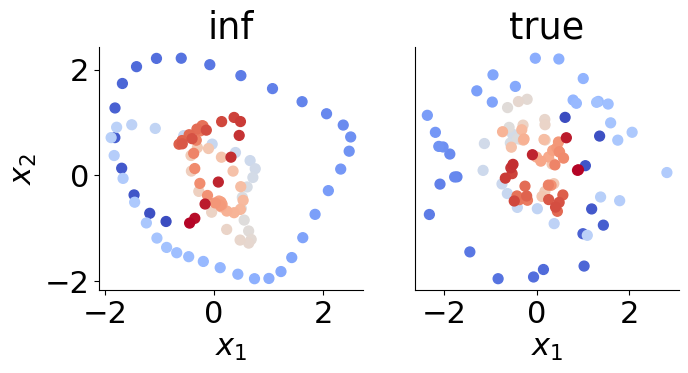

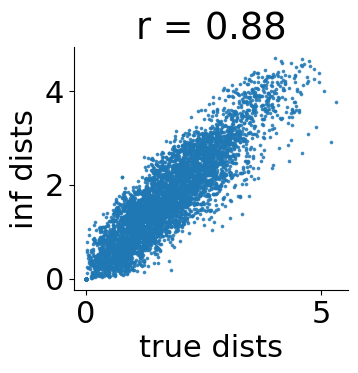

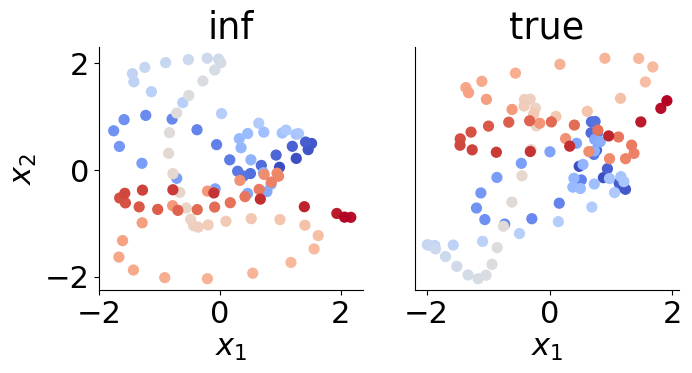

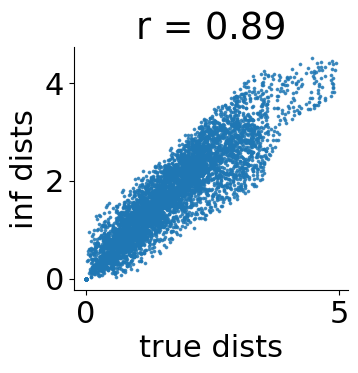

In [10]:
comp_lats([Xgplvm1, X1], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xgplvm1, X1)

print('\n')

comp_lats([Xgplvm2, X2], cs = [np.arange(T) for _ in range(2)], cmap = 'coolwarm', titles = ['inf', 'true'])
eval_lats(Xgplvm2, X2)

We see that the non-linear model does a substantially better job at modelling the nonlinear data while still doing reasonably well on the linear data.
To investigate this point, we consider the _tuning curves_ for a few example neurons on either the linear or nonlinear data.
On the linear data, we see that the nonlinear GPLVM still has the capacity to learn approximately linear functions - although with some margin of error, which will get increasingly large as the dataset becomes smaller and more noisy.
In contrast, this added flexbility is _necessary_ to fit the non-linear dataset, where the linear methods have to cook up some weird approximations.

However, while the linear methods struggle to capture the latent space in 2 dimensions, they may still have good predictive accuracy at the level of neural firing rates in higher dimensions.
This is because a nonlinear manifold with an intrinsic dimensionality of 2 may still be embedded and well described in higher-dimensional linear spaces.
Such considerations can have important consequences for our analyses, if we e.g. use unsupervised learning to estimate the _dimensionality_ of neural data.
In this case, the result of our analysis might differ substantially depending on whether we use linear or non-linear methods, and we should generally keep this in mind when interpreting the results of our data analysis.

Of course the increased flexibility of the nonlinear model also comes at the cost of more expensive training and inference.
In particular, we have to rely on either the Laplace approximation (Wu et al.) or variational inference (Jensen et al.), which can be both computationally expensive and lose any guarantees we may have of convergence in the simpler linear models.

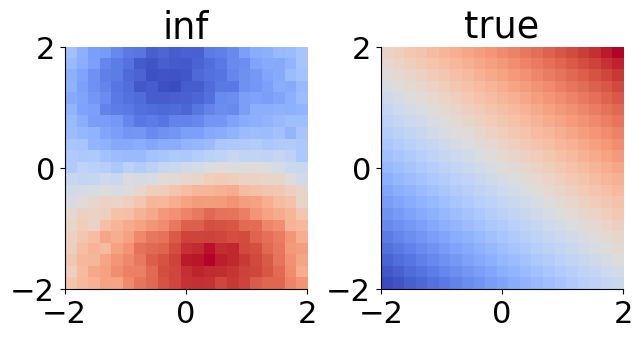

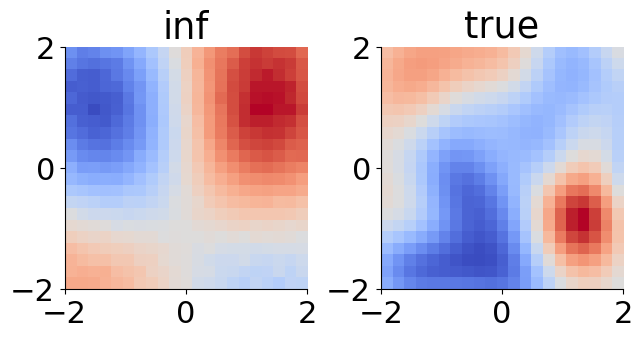

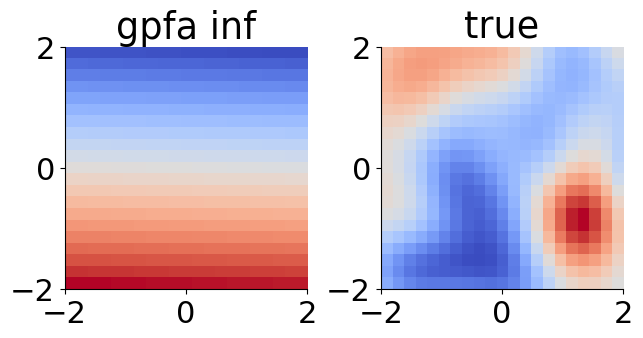

In [11]:
query_pytorch = torch.tensor(Xt, dtype=torch.get_default_dtype())[None, ...] #reformat for pytorch
samples1 = mod_gplvm1.obs.sample(query_pytorch, 200, noise = False)
Y1mgplvm_t = samples1.mean(0).detach().cpu().numpy()[0, ...] #find the mean
samples2 = mod_gplvm2.obs.sample(query_pytorch, 200, noise = False)
Y2mgplvm_t = samples2.mean(0).detach().cpu().numpy()[0, ...] #find the mean

comp_tuning([Y1mgplvm_t, Y1_t], [Xt, Xt], titles = ['inf', 'true'], n = 0)
comp_tuning([Y2mgplvm_t, Y2_t], [Xt, Xt], titles = ['inf', 'true'], n = 1)

mu, v = mod_gpfa1.obs.predict(query_pytorch[None, ...], False)
Y2gpfa_t = mu.detach().cpu().numpy()[0, 0, ...]
comp_tuning([Y2gpfa_t, Y2_t], [Xt, Xt], titles = ['gpfa inf', 'true'], n = 1)

### Note that the 'inferred' and 'true' latent spaces may be rotated relative to each other.
### For this reason, we should only consider the shape and not the orientation of the tuning curves. 

## Outlook

Finally note that there are many other extensions and variants.
E.g. non-Gaussian noise models, non-Euclidean latent spaces, non-linear dynamical systems.
Indeed the purpose of this notebook is not give a comprehensive overview of all existing methods, but instead to highlight the importance of the types of _priors_ and inductive biases used by common analytic tools in the neuroscience literature.
For a more systematic overview of latent variable models in neuroscience, we refer to e.g. Roweis & Ghahramani (1999), Cunningham & Yu (2014), Duncker & Sahani (2021).